In [2]:
%matplotlib inline

import json
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm, tqdm_notebook

In [3]:
tqdm_notebook().pandas()

pd.set_option('precision',2)

sns.set_style("darkgrid")

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [4]:
data_folder = Path("data/pkp/")
input_file = data_folder / "PKP_20171220.csv"

In [5]:
def extract_fb_shares(df):
    result_cols = [
        'pkp', 'pkp_ogid',
        'pmid', 'pmid_ogid',
        'pmc', 'pmc_ogid',
        'doi', 'doi_ogid',
        'total'
    ]
    shares = pd.DataFrame(columns=result_cols, index=set(df.index))
    
    rows = list(df[df.og_obj.notnull()].itertuples())
    for row in tqdm_notebook(rows, total=len(rows)):
        shares.loc[row.Index, row.type.split("_")[0] + "_ogid"] = str(json.loads(row.og_obj)['id'])
        shares.loc[row.Index, row.type.split("_")[0]] = float(json.loads(row.og_eng)['share_count'])
        
    return shares

def extract_am_shares(df):
    result_cols = ['am', 'am_id']
    shares = pd.DataFrame(columns=result_cols, index=set(df.index))
    
    rows = list(df[df.am_resp.notnull()].itertuples())
    for row in tqdm_notebook(rows, total=len(rows)):
        if pd.notnull(row.am_resp):
            try:
                shares.loc[row.Index, "am_id"] = str(json.loads(row.am_resp)['altmetric_id'])
            except:
                shares.loc[row.Index, "am_id"] = None
            try:
                shares.loc[row.Index, "am"] =  float(json.loads(row.am_resp)['counts']['facebook']['posts_count'])
            except:
                shares.loc[row.Index, "am"] = 0.0
        #if pd.notnull(row.og_eng):
        #    shares.loc[row.doi, row.type.split("_")[0]] =  int(json.loads(row.og_eng)['share_count'])
        
    return shares

In [6]:
df_input = pd.read_csv(input_file,
                       index_col="doi",
                       parse_dates=["date"]).drop_duplicates()

am_results = pd.read_csv(data_folder / "am_responses.csv",
                         index_col="doi",
                         parse_dates=['am_ts'])
fb_results = pd.read_csv(data_folder / "fb_responses.csv",
                         index_col="doi",
                         parse_dates=['ts'],
                         dtype={'doi': str, 'type': str, 'url': str, 'og_obj': str, 'og_eng': str, 'og_err': str})
am_results = am_results.replace("null", np.nan)

In [7]:
fb_shares = extract_fb_shares(fb_results)
am_shares = extract_am_shares(am_results)

HBox(children=(IntProgress(value=0, max=63027), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15953), HTML(value='')))

In [9]:
# Some URLs have been assigned to the same Facebook OG IDs
# Those share numbers should be investigated in more detail
# but for now they are simply being overwritten with NaNs

ids = ['pkp_ogid', 'pmc_ogid', 'pmid_ogid', 'doi_ogid']

for _ in ids:
    bad_ones = fb_shares[(~fb_shares[_].isnull() & fb_shares.duplicated(subset=[_], keep=False))].index
    fb_shares.loc[bad_ones, _.split("_")[0]] = np.nan
    print("Duplicate {} IDs: {}".format(_, len(bad_ones)))

Duplicate pkp_ogid IDs: 303
Duplicate pmc_ogid IDs: 0
Duplicate pmid_ogid IDs: 0
Duplicate doi_ogid IDs: 41


In [8]:
fb_shares[['pkp', 'pmid', 'doi', 'pmc']] = fb_shares[['pkp', 'pmid', 'doi', 'pmc']].astype(float)
am_shares['am'] = am_shares['am'].astype(float)

In [10]:
# Sum of the individual FB shares (doi, pkp, pmc, pmid) but taking
# into account that some URLs are identical for resolved DOI and
# original PKP ones.
# 
# DOI == PKP: sum(pkp, pmc, pmid)
# DOI != PKP: sum(pkp, doi, pmc, pmid)

x = fb_results[fb_results.type.isin(['pkp_url', 'doi_url'])][['url']].copy()
x['netloc'] = x.url.apply(lambda x: urllib.parse.urlparse(x).netloc)
x['path'] = x.url.apply(lambda x: urllib.parse.urlparse(x).path)
doi_pkp_identical = x[x[['netloc', 'path']].duplicated()].index

fb_shares['fb'] = fb_shares[['pkp', 'pmc', 'pmid', 'doi']].sum(axis=1)
fb_shares.loc[doi_pkp_identical, 'fb'] = fb_shares.loc[doi_pkp_identical, ['pkp', 'pmc', 'pmid']].sum(axis=1)

In [169]:
# Merge FB shares, AM shares, publication years, and the diff between FB & AM

shares = fb_shares.merge(am_shares, left_index=True, right_index=True)[['pkp', 'doi', 'pmid', 'pmc', 'fb', 'am']]
shares = shares.merge(df_input[['date', 'year']], left_index=True, right_index=True)
shares['diff'] = shares['fb'] - shares['am']

In [171]:
# Also restrict to a certain timespan

min_year = 2010
max_year = 2017
smaller = shares[shares['year'].between(min_year, max_year)]
print("Total number of removed rows: {}".format(len(shares) - len(smaller)))
shares = smaller

Total number of removed rows: 80228


## Descriptive Stats

In [13]:
# Notnull values
shares.describe()

,pkp,pmid,pmc,doi,fb,am,year,diff
count,26256.00,391.00,3647.00,18725.00,43917.00,14585.00,197107.00,9764.00
mean,0.85,2.75,0.76,0.84,0.95,0.82,2014.13,1.41
std,12.13,25.04,8.63,4.10,12.22,3.21,2.20,22.24
min,0.00,0.00,0.00,0.00,0.00,0.00,2010.00,-70.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,2012.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,0.00
75%,1.00,1.00,0.00,1.00,1.00,1.00,2016.00,1.00
max,1847.00,396.00,303.00,310.00,2081.00,276.00,2017.00,1805.00


In [14]:
# Nulls filled with 0s ()
shares.fillna(0).describe()

,pkp,pmid,pmc,doi,total,fb,am,year,diff
count,197107.00,1.97e+05,197107.00,197107.00,197107.0,197107.00,197107.00,197107.00,197107.00
mean,0.11,5.45e-03,0.01,0.08,0.0,0.21,0.06,2014.13,0.07
std,4.44,1.12e+00,1.18,1.29,0.0,5.78,0.90,2.20,4.96
min,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,2010.00,-70.00
25%,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,2012.00,0.00
50%,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,2015.00,0.00
75%,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,2016.00,0.00
max,1847.00,3.96e+02,303.00,310.00,0.0,2081.00,276.00,2017.00,1805.00


In [15]:
# Small set of papers that had all 4 URLs
shares[(shares.pkp.notnull()) & (shares.pmid.notnull()) & (shares.pmc.notnull()) & (shares.doi.notnull())].describe()

,pkp,pmid,pmc,doi,fb,am,year,diff
count,25.00,25.0,25.00,25.00,25.00,24.00,25.00,24.00
mean,95.88,19.4,20.44,2.76,138.48,27.62,2014.24,116.50
std,372.25,79.6,64.61,7.79,458.93,61.80,1.64,410.79
min,0.00,0.0,0.00,0.00,1.00,0.00,2011.00,-70.00
25%,1.00,0.0,0.00,0.00,3.00,1.00,2013.00,0.75
50%,2.00,0.0,2.00,0.00,7.00,2.00,2014.00,2.00
75%,9.00,0.0,4.00,1.00,20.00,10.00,2016.00,11.00
max,1847.00,396.0,303.00,33.00,2081.00,276.00,2016.00,1805.00


In [16]:
# Compare those articles that were found on Altmetric
shares[shares.am.notnull()].describe()

,pkp,pmid,pmc,doi,fb,am,year,diff
count,6716.00,309.00,2833.00,3067.00,9764.00,14585.00,14585.00,9764.00
mean,2.23,3.37,0.94,1.72,2.44,0.82,2014.33,1.41
std,23.74,28.15,9.78,5.01,25.27,3.21,1.95,22.24
min,0.00,0.00,0.00,0.00,0.00,0.00,2010.00,-70.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,0.00
50%,1.00,0.00,0.00,1.00,1.00,0.00,2015.00,0.00
75%,2.00,1.00,0.00,2.00,2.00,1.00,2016.00,1.00
max,1847.00,396.00,303.00,136.00,2081.00,276.00,2017.00,1805.00


In [40]:
shares.replace(0, np.nan).describe()

,pkp,pmid,pmc,doi,total,fb,am,year,diff
count,7405.00,121.00,563.00,5677.00,0.0,13042.00,6532.00,197107.00,5238.00
mean,3.01,8.88,4.93,2.76,NaN,3.18,1.82,2014.13,2.63
std,22.70,44.54,21.50,7.08,NaN,22.27,4.60,2.20,30.31
min,1.00,1.00,1.00,1.00,NaN,1.00,1.00,2010.00,-70.00
25%,1.00,1.00,1.00,1.00,NaN,1.00,1.00,2012.00,-1.00
50%,1.00,1.00,1.00,1.00,NaN,1.00,1.00,2015.00,1.00
75%,3.00,2.00,3.00,3.00,NaN,3.00,2.00,2016.00,2.00
max,1847.00,396.00,303.00,310.00,NaN,2081.00,276.00,2017.00,1805.00


In [93]:
shares.dropna().describe()

,pkp,doi,pmid,pmc,fb,am,year,diff
count,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00
mean,99.88,2.83,20.21,21.21,144.12,27.62,2014.25,116.50
std,379.71,7.94,81.20,65.89,467.91,61.80,1.67,410.79
min,1.00,0.00,0.00,0.00,1.00,0.00,2011.00,-70.00
25%,1.00,0.00,0.00,0.00,2.75,1.00,2013.00,0.75
50%,2.50,0.00,0.00,2.00,7.00,2.00,2014.00,2.00
75%,9.00,1.00,0.25,4.25,21.75,10.00,2016.00,11.00
max,1847.00,33.00,396.00,303.00,2081.00,276.00,2016.00,1805.00


## Plots

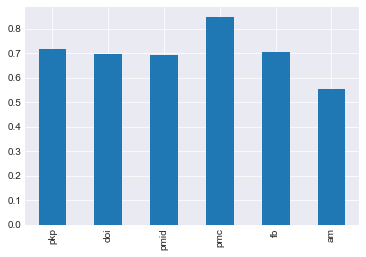

In [71]:
# Ratio of results with 0 shares
shares.apply(lambda x: x==0).sum().div(shares.count())[['pkp', 'doi', 'pmid', 'pmc', 'fb', 'am']].plot(kind="bar");

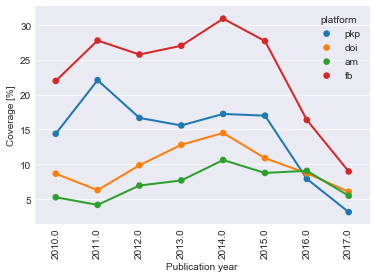

In [176]:
# Coverage
_ = shares.groupby('year')[['pkp', 'doi', 'am', 'fb']].apply(lambda x: x.notnull().mean()*100).reset_index()
_ = _.melt(id_vars = ['year'], var_name="platform", value_name="coverage")
sns.pointplot(x="year", y="coverage", hue="platform", data=_,
             scale=0.75)
plt.xticks(rotation=90);
plt.ylabel("Coverage [%]");
plt.xlabel("Publication year");

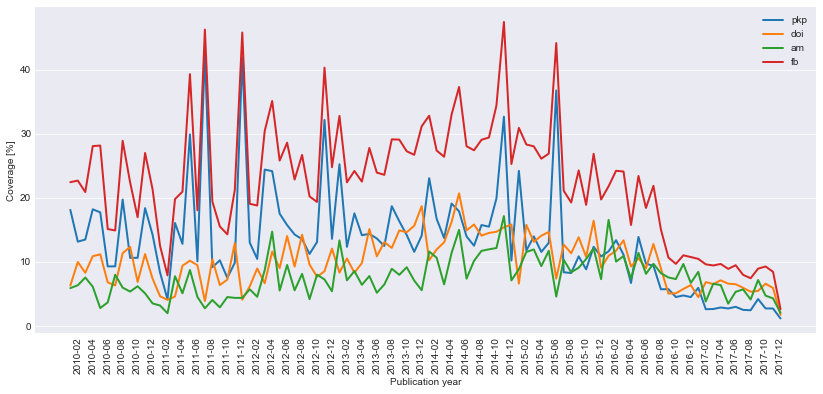

In [255]:
# Coverage
platforms = ['pkp', 'doi', 'am', 'fb']

_ = shares.set_index('date').groupby(pd.TimeGrouper('M'))[platforms].apply(lambda x: x.notnull().mean()*100).reset_index()
_['date'] = _['date'].dt.strftime('%Y-%m')
_ = _.melt(id_vars = ['date'], var_name="platform", value_name="coverage")

plt.figure(figsize=(14,6))
for line in _.platform.unique().tolist():
    __ = _[_.platform == line].sort_values('date')
    plt.plot(__['date'], __['coverage'], lw=2, marker="")

plt.legend(platforms)
plt.xticks(rotation=90);
plt.ylabel("Coverage [%]");
plt.xlabel("Publication year");
plt.setp(plt.gca().get_xticklabels()[::2], visible=False);
plt.gca().xaxis.grid(False)

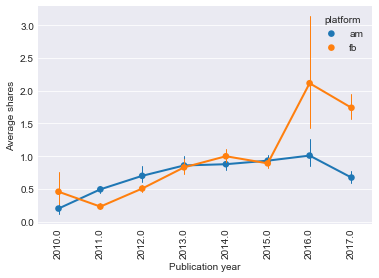

In [73]:
_ = shares[['year', 'am', 'fb']].melt(id_vars = ['year'], var_name="platform", value_name="shares")
sns.pointplot(x="year", y="shares", hue="platform",
              data=_, scale=.75, errwidth=1);
plt.xticks(rotation=90);
plt.ylabel("Average shares");
plt.xlabel("Publication year");

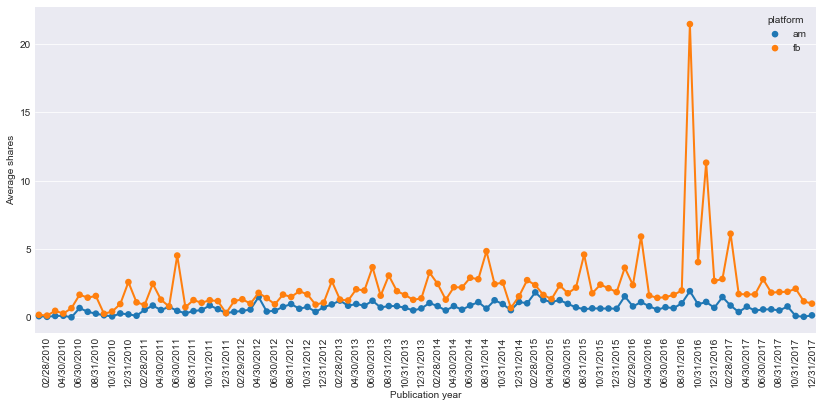

In [215]:
_ = shares[shares.am.notnull()][['date', 'am', 'fb']].set_index('date').groupby(pd.TimeGrouper('M')).mean()
_ = _.reset_index().melt(id_vars = ['date'], var_name="platform", value_name="shares")
_['date'] = _['date'].dt.strftime('%m/%d/%Y')
plt.figure(figsize=(14,6))
sns.pointplot(x="date", y="shares", hue="platform",
              data=_, scale=.75);
plt.xticks(rotation=90);
plt.setp(plt.gca().get_xticklabels()[::2], visible=False)
plt.ylabel("Average shares");
plt.xlabel("Publication year");

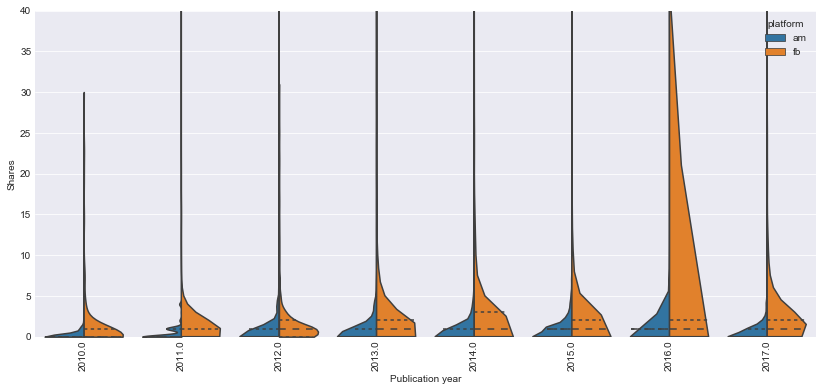

In [160]:
_ = shares[shares.am.notnull()][['year', 'am', 'fb']].melt(id_vars = ['year'], var_name="platform", value_name="shares")

plt.figure(figsize=(14,6))
sns.violinplot(x="year", y="shares", hue="platform", scale="width", 
              data=_, split=True, scale_hue=True, inner="quartile", cut=0);
plt.xticks(rotation=90);
plt.ylabel("Shares");
plt.xlabel("Publication year");
plt.ylim(0, 40);

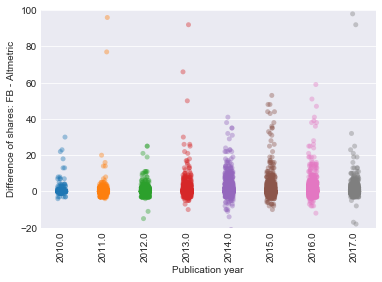

In [81]:
sns.stripplot(x="year", y="diff", data=shares, jitter=True, dodge=True, alpha=.4);
plt.xticks(rotation=90);
plt.ylim(-20,100)
plt.ylabel('Difference of shares: FB - Altmetric');
plt.xlabel("Publication year");

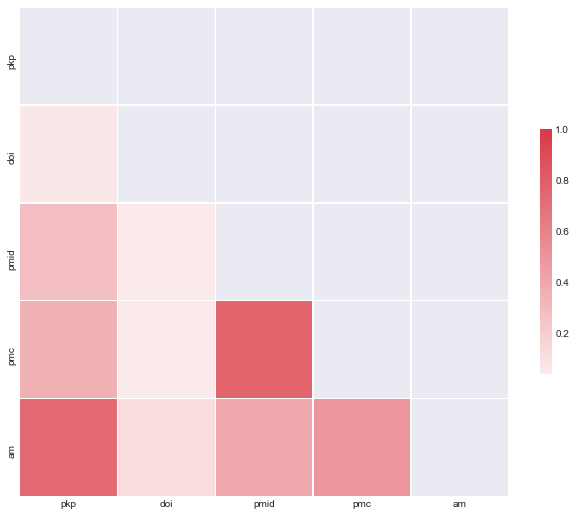

In [89]:
corr = shares.fillna(0)[['pkp', 'doi', 'pmid', 'pmc', 'am']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})